In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sys, platform
print("Python:", sys.version)
print("OS:", platform.platform())

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import types as T


Python: 3.12.2 (tags/v3.12.2:6abddd9, Feb  6 2024, 21:26:36) [MSC v.1937 64 bit (AMD64)]
OS: Windows-11-10.0.26200-SP0


In [4]:
spark = SparkSession.builder.appName("Midterm Project").getOrCreate()
spark

In [8]:
data_path = "../data/raw/medical_insurance.csv"
df = spark.read.csv(data_path, header=True, inferSchema=True)

print("Total rows:", df.count())
df.limit(5).toPandas()

Total rows: 100000


,person_id,age,sex,region,urban_rural,income,education,marital_status,employment_status,household_size,...,liver_disease,arthritis,mental_health,proc_imaging_count,proc_surgery_count,proc_physio_count,proc_consult_count,proc_lab_count,is_high_risk,had_major_procedure
0,75722,52,Female,North,Suburban,22700.0,Doctorate,Married,Retired,3,...,0,1,0,1,0,2,0,1,0,0
1,80185,79,Female,North,Urban,12800.0,No HS,Married,Employed,3,...,0,1,1,0,0,1,0,1,1,0
2,19865,68,Male,North,Rural,40700.0,HS,Married,Retired,5,...,0,0,1,1,0,2,1,0,1,0
3,76700,15,Male,North,Suburban,15600.0,Some College,Married,Self-employed,5,...,0,0,0,1,0,0,1,0,0,0
4,92992,53,Male,Central,Suburban,89600.0,Doctorate,Married,Self-employed,2,...,0,1,0,2,0,1,1,0,1,0


In [9]:
df.printSchema()

root
 |-- person_id: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- region: string (nullable = true)
 |-- urban_rural: string (nullable = true)
 |-- income: double (nullable = true)
 |-- education: string (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- employment_status: string (nullable = true)
 |-- household_size: integer (nullable = true)
 |-- dependents: integer (nullable = true)
 |-- bmi: double (nullable = true)
 |-- smoker: string (nullable = true)
 |-- alcohol_freq: string (nullable = true)
 |-- visits_last_year: integer (nullable = true)
 |-- hospitalizations_last_3yrs: integer (nullable = true)
 |-- days_hospitalized_last_3yrs: integer (nullable = true)
 |-- medication_count: integer (nullable = true)
 |-- systolic_bp: double (nullable = true)
 |-- diastolic_bp: double (nullable = true)
 |-- ldl: double (nullable = true)
 |-- hba1c: double (nullable = true)
 |-- plan_type: string (nullable = true)
 |-

In [10]:
# missing values
missing_counts = df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns])
missing_counts.show()

+---------+---+---+------+-----------+------+---------+--------------+-----------------+--------------+----------+---+------+------------+----------------+--------------------------+---------------------------+----------------+-----------+------------+---+-----+---------+------------+----------+-----+-----------------+------------------------+----------------+----------+-------------------+--------------+---------------+------------+----------------+-----------------+-------------+------------+--------+------+----+----------------------+--------------+--------------+-------------+---------+-------------+------------------+------------------+-----------------+------------------+--------------+------------+-------------------+
|person_id|age|sex|region|urban_rural|income|education|marital_status|employment_status|household_size|dependents|bmi|smoker|alcohol_freq|visits_last_year|hospitalizations_last_3yrs|days_hospitalized_last_3yrs|medication_count|systolic_bp|diastolic_bp|ldl|hba1c|pla

In [11]:
num_cols = ['age','income','bmi','annual_medical_cost','annual_premium','monthly_premium','claims_count','avg_claim_amount']
df.select(num_cols).describe().toPandas().T

,0,1,2,3,4
summary,count,mean,stddev,min,max
age,100000,47.5215,15.988752113656073,0,100
income,100000,49873.905,46800.21412719603,1100.0,1061800.0
bmi,100000,26.990511999999992,4.994882507764189,12.0,50.4
annual_medical_cost,100000,3009.451907000008,3127.4628223865643,55.55,65724.9
annual_premium,100000,582.3200397000005,399.58372199751375,211.67,10962.55
monthly_premium,100000,48.52666820000009,33.29863999101709,17.64,913.55
claims_count,100000,1.62178,2.029820394347329,0,23
avg_claim_amount,100000,656.5120837000012,1072.6600483424254,0.0,30010.53


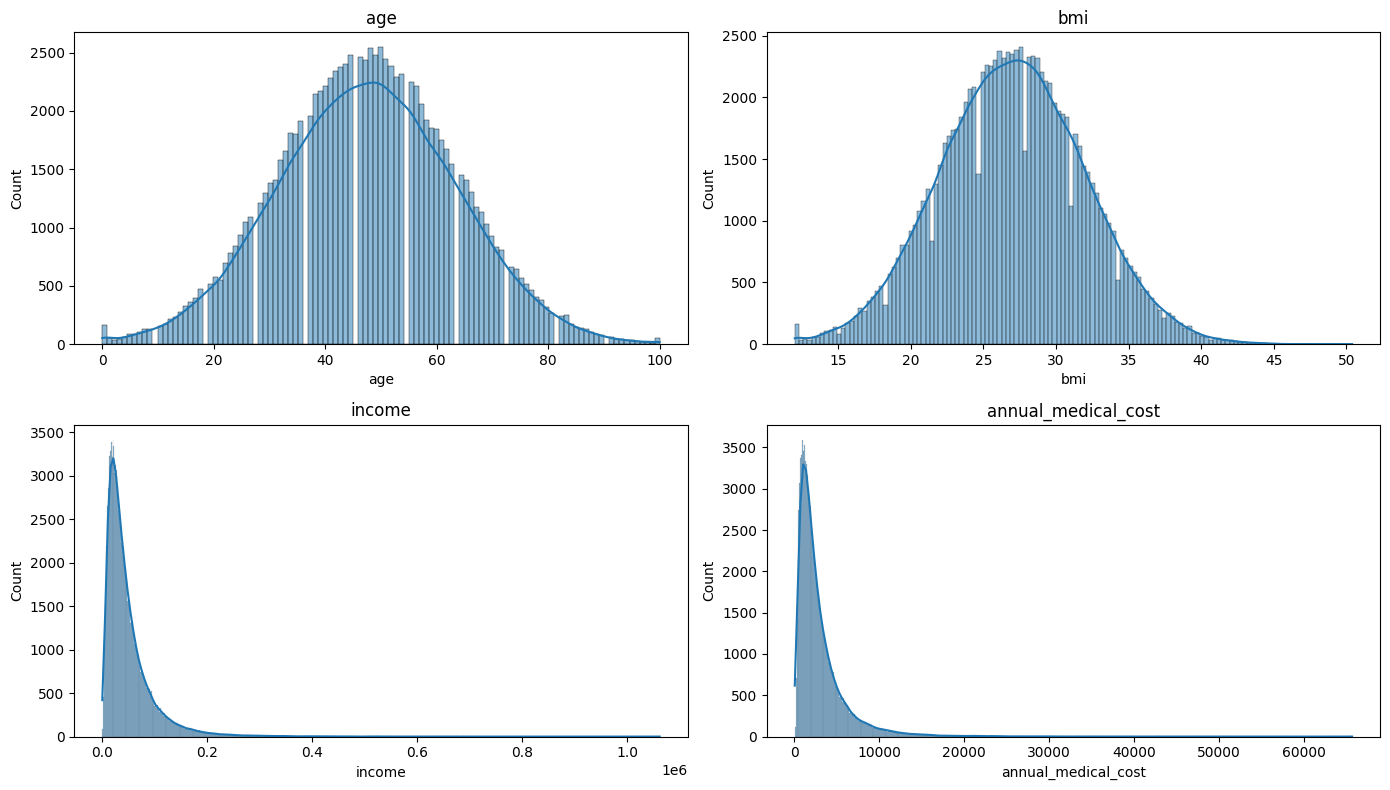

In [12]:
plt.figure(figsize=(14,8))
pdf = df.select(['age','bmi','income','annual_medical_cost']).toPandas()
for i, col in enumerate(['age','bmi','income','annual_medical_cost']):
  plt.subplot(2,2,i+1)
  sns.histplot(pdf[col].dropna(), kde=True)
  plt.title(col)
plt.tight_layout()
plt.show()

In [13]:
cat_cols = ['sex','region','urban_rural','education','marital_status','employment_status','smoker','plan_type']
for c in cat_cols:
  print("---", c, "---")
  counts = df.groupBy(c).count().withColumn("percentage", (F.col("count") / df.count() * 100).cast("decimal(10,2)")).orderBy(F.col("count").desc())
  counts.show(10, truncate=False)
  print()

--- sex ---
+------+-----+----------+
|sex   |count|percentage|
+------+-----+----------+
|Female|49193|49.19     |
|Male  |48794|48.79     |
|Other |2013 |2.01      |
+------+-----+----------+


--- region ---
+-------+-----+----------+
|region |count|percentage|
+-------+-----+----------+
|South  |28029|28.03     |
|North  |22027|22.03     |
|East   |19984|19.98     |
|West   |17879|17.88     |
|Central|12081|12.08     |
+-------+-----+----------+


--- urban_rural ---
+-----------+-----+----------+
|urban_rural|count|percentage|
+-----------+-----+----------+
|Urban      |60019|60.02     |
|Suburban   |25021|25.02     |
|Rural      |14960|14.96     |
+-----------+-----+----------+


--- education ---
+------------+-----+----------+
|education   |count|percentage|
+------------+-----+----------+
|Bachelors   |27996|28.00     |
|Some College|25112|25.11     |
|HS          |24827|24.83     |
|Masters     |13987|13.99     |
|No HS       |5120 |5.12      |
|Doctorate   |2958 |2.96      |

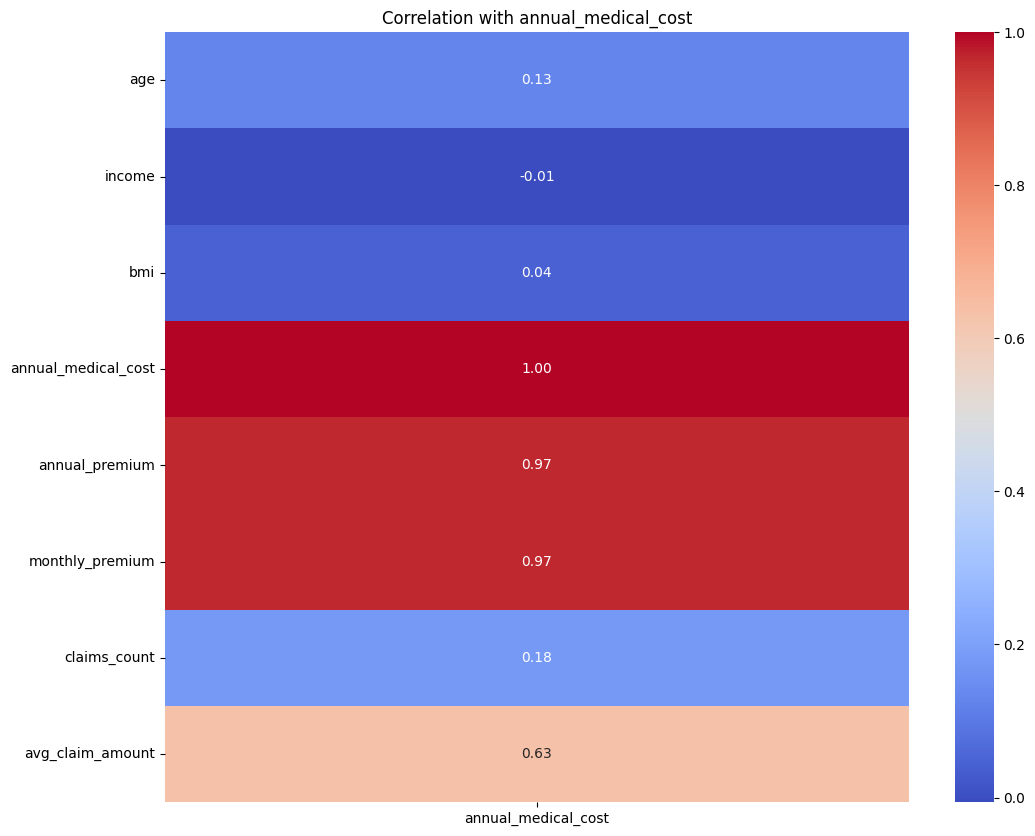

In [17]:
pdf_corr = df.select(num_cols).toPandas()
corr = pdf_corr.corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr.loc[['annual_medical_cost']].T, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation with annual_medical_cost")
plt.show()

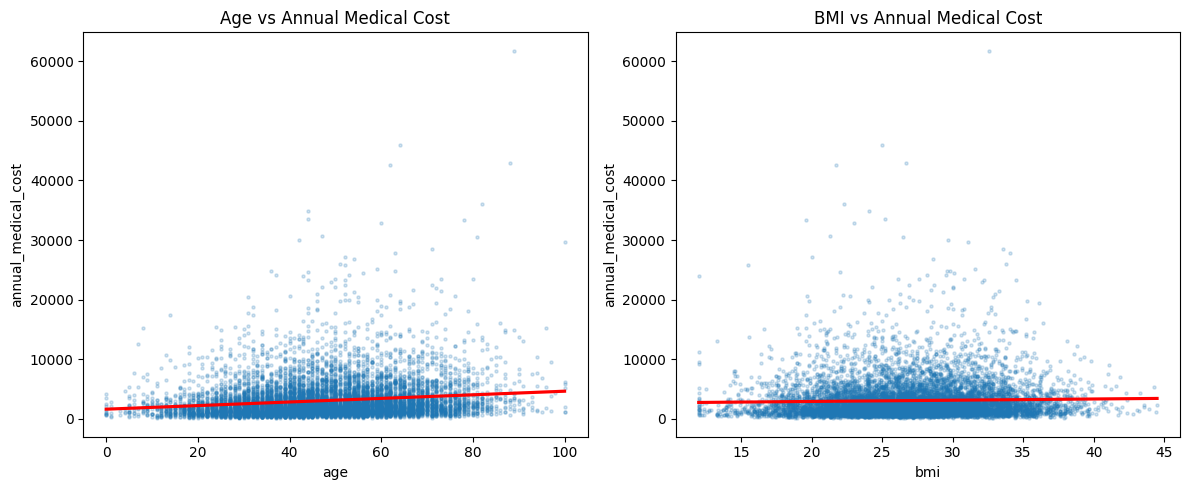

In [18]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
pdf_sample = df.select(['age', 'bmi', 'annual_medical_cost']).sample(False, 0.1).toPandas()
sns.regplot(x='age', y='annual_medical_cost', data=pdf_sample, scatter_kws={'s':5,'alpha':0.2}, line_kws={'color':'red'})
plt.title('Age vs Annual Medical Cost')

plt.subplot(1,2,2)
sns.regplot(x='bmi', y='annual_medical_cost', data=pdf_sample, scatter_kws={'s':5,'alpha':0.2}, line_kws={'color':'red'})
plt.title('BMI vs Annual Medical Cost')
plt.tight_layout()
plt.show()

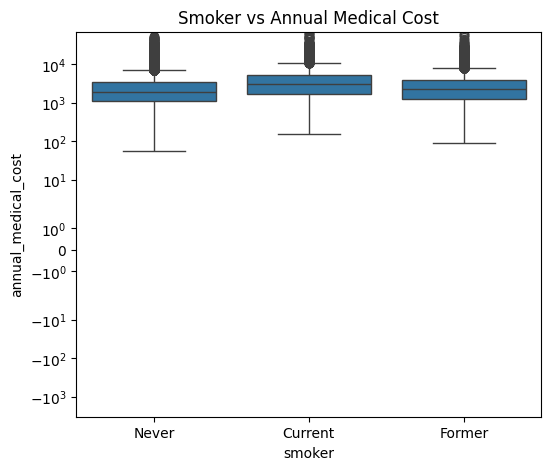

In [19]:
plt.figure(figsize=(6,5))
pdf_smoker = df.select(['smoker', 'annual_medical_cost']).toPandas()
sns.boxplot(x='smoker', y='annual_medical_cost', data=pdf_smoker)
plt.yscale('symlog')
plt.title('Smoker vs Annual Medical Cost')
plt.show()